# 径向本征求解器

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/02-solver.ipynb)

## 学习目标

- 理解径向薛定谔方程的数值求解方法
- 对比不同求解器（FD2/FD5）的精度差异
- 验证氢原子解析解并分析数值误差

## 径向薛定谔方程

球对称势下的径向方程：

$$\left[-\frac{1}{2}\frac{d^2}{dr^2} + \frac{l(l+1)}{2r^2} + V(r)\right] u(r) = E u(r)$$

其中 $u(r) = r R(r)$ 是径向约化波函数，边界条件：$u(0) = 0$，$u(\infty) = 0$。

## 理论基础：有限差分法

径向薛定谔方程：

$$\left[-\frac{1}{2}\frac{d^2}{dr^2} + \frac{l(l+1)}{2r^2} + V(r)\right]u(r) = Eu(r)$$

### 五点中心差分（O(h⁴) 精度）

二阶导数离散化：

$$\frac{d^2u}{dr^2}\bigg|_i \approx \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

构造 Hamiltonian 矩阵 $H$，求解广义本征值问题：

$$H\mathbf{u} = E\mathbf{u}$$

**算法实现**：
1. 构造五对角矩阵 `H`
2. 调用 `scipy.linalg.eigh()` 求解
3. 提取束缚态（$E < 0$）并归一化


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.operator import solve_bound_states_fd, solve_bound_states_fd5

plt.rcParams["figure.figsize"] = (12, 5)

## 氢原子势函数

类氢离子的库仑势：$V(r) = -Z/r$

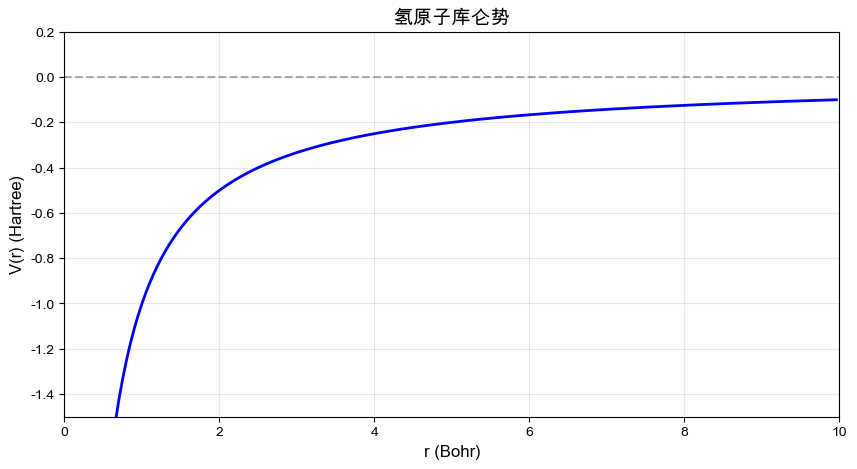

In [4]:
# 生成网格
r, w = radial_grid_linear(n=1000, rmin=1e-5, rmax=50.0)

# 氢原子势 (Z=1)
Z = 1
V_H = -Z / np.maximum(r, 1e-12)  # 防止除零

# 可视化势函数
plt.figure(figsize=(10, 5))
plt.plot(r[:200], V_H[:200], "b-", linewidth=2)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.3)
plt.xlabel("r (Bohr)", fontsize=12)
plt.ylabel("V(r) (Hartree)", fontsize=12)
plt.title("氢原子库仑势", fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(0, 10)
plt.ylim(-1.5, 0.2)
plt.show()

## 求解氢原子轨道

使用 FD2 和 FD5 方法分别求解 1s, 2s, 2p 轨道：

In [5]:
# 定义要求解的轨道
orbitals = [
    {"n": 1, "l": 0, "label": "1s", "n_idx": 0},
    {"n": 2, "l": 0, "label": "2s", "n_idx": 1},
    {"n": 2, "l": 1, "label": "2p", "n_idx": 0},
]

results_fd = []
results_fd5 = []

print("氢原子轨道能量对比：\n")
print("轨道 | 解析解 (Ha) | FD2 (Ha) | FD2 误差 | FD5 (Ha) | FD5 误差")
print("-" * 75)

for orb in orbitals:
    n, l = orb["n"], orb["l"]
    label = orb["label"]
    n_idx = orb["n_idx"]  # 该 l 通道中的索引
    
    # 解析解
    E_exact = -Z**2 / (2 * n**2)
    
    # 求解需要的本征态数量（至少要包含该轨道）
    k_states = n_idx + 1
    
    # FD2 求解（二阶精度）
    # 注意：solve_bound_states_fd 返回 (k_states, n_points) 形状的数组
    eps_fd, u_fd = solve_bound_states_fd(r, l, V_H, k_states)
    E_fd = eps_fd[n_idx]
    u_fd_orb = u_fd[n_idx, :]  # 提取第 n_idx 行（对应该本征态的波函数）
    error_fd = abs(E_fd - E_exact) / abs(E_exact)
    
    # FD5 求解（四阶精度，需要等距网格）
    eps_fd5, u_fd5 = solve_bound_states_fd5(r, l, V_H, k_states)
    E_fd5 = eps_fd5[n_idx]
    u_fd5_orb = u_fd5[n_idx, :]  # 提取第 n_idx 行
    error_fd5 = abs(E_fd5 - E_exact) / abs(E_exact)
    
    # 保存结果
    results_fd.append({"label": label, "n": n, "l": l, "energy": E_fd, "wavefunction": u_fd_orb})
    results_fd5.append({"label": label, "n": n, "l": l, "energy": E_fd5, "wavefunction": u_fd5_orb})
    
    print(f"{label:4s} | {E_exact:11.8f} | {E_fd:8.6f} | {error_fd:8.2e} | {E_fd5:8.6f} | {error_fd5:8.2e}")

## 波函数可视化

绘制径向波函数并检查节点结构：

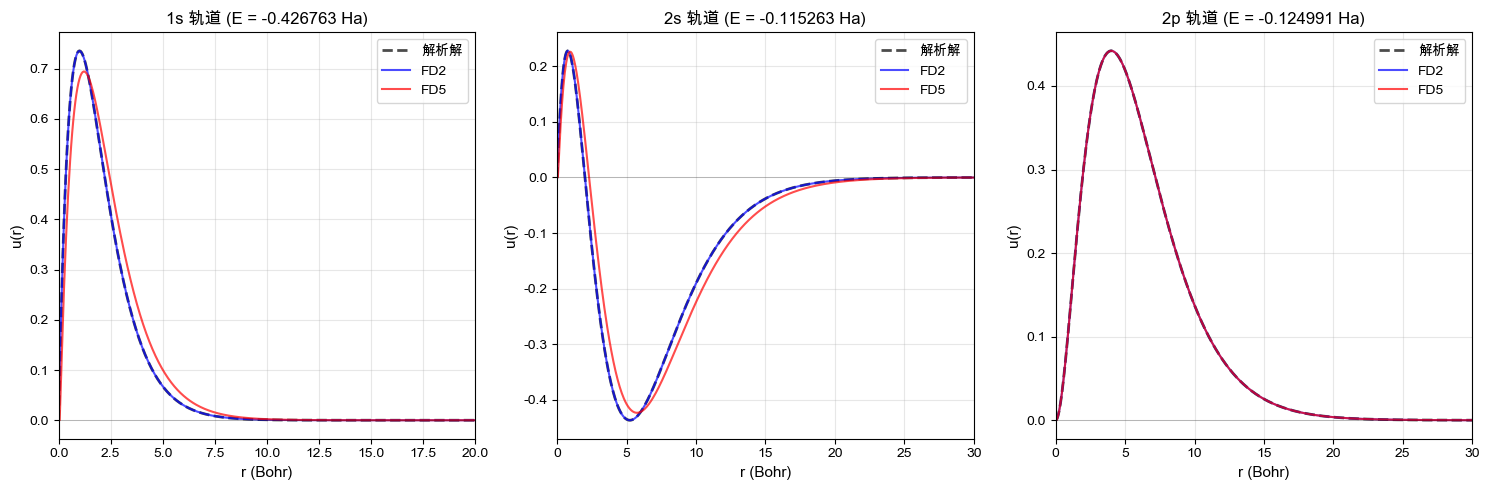

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, res_fd, res_fd5) in enumerate(zip(axes, results_fd, results_fd5)):
    label = res_fd["label"]
    u_fd = res_fd["wavefunction"]
    u_fd5 = res_fd5["wavefunction"]
    E_fd = res_fd["energy"]
    E_fd5 = res_fd5["energy"]
    
    # 氢原子解析解（归一化）
    if label == "1s":
        u_exact = 2 * Z**1.5 * r * np.exp(-Z * r)
    elif label == "2s":
        u_exact = (Z / 2)**1.5 / np.sqrt(2) * r * (2 - Z * r) * np.exp(-Z * r / 2)
    elif label == "2p":
        u_exact = (Z / 2)**1.5 / np.sqrt(24) * (Z * r)**2 * np.exp(-Z * r / 2)
    
    # 归一化解析解
    norm_exact = np.sqrt(np.sum(u_exact**2 * w))
    u_exact /= norm_exact
    
    # 调整符号使其一致
    if np.sum(u_fd * u_exact) < 0:
        u_fd = -u_fd
    if np.sum(u_fd5 * u_exact) < 0:
        u_fd5 = -u_fd5
    
    # 绘图
    ax.plot(r, u_exact, "k--", linewidth=2, label="解析解", alpha=0.7)
    ax.plot(r, u_fd, "b-", linewidth=1.5, label="FD2", alpha=0.7)
    ax.plot(r, u_fd5, "r-", linewidth=1.5, label="FD5", alpha=0.7)
    ax.axhline(y=0, color="k", linestyle="-", linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel("r (Bohr)", fontsize=11)
    ax.set_ylabel("u(r)", fontsize=11)
    ax.set_title(f"{label} 轨道 (E = {E_fd5:.6f} Ha)", fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 20 if label == "1s" else 30)
    ax.legend()

plt.tight_layout()
plt.show()

print("\n节点规律（节点数 = n - l - 1）:")
for res in results_fd:
    u = res["wavefunction"]
    nodes = np.sum(np.diff(np.sign(u)) != 0) // 2
    expected_nodes = res["n"] - res["l"] - 1
    print(f"  {res['label']}: {nodes} 个节点（理论: {expected_nodes}）")

## 归一化检验

验证波函数满足归一化条件 $\int_0^\infty u^2(r) dr = 1$：

In [7]:
print("归一化检验:\n")
for res_fd, res_fd5 in zip(results_fd, results_fd5):
    label = res_fd["label"]
    u_fd = res_fd["wavefunction"]
    u_fd5 = res_fd5["wavefunction"]
    
    norm_fd = np.sum(u_fd**2 * w)
    norm_fd5 = np.sum(u_fd5**2 * w)
    
    print(f"{label} 轨道:")
    print(f"  FD2:  ∫u² dr = {norm_fd:.8f}")
    print(f"  FD5:  ∫u² dr = {norm_fd5:.8f}")
    print(f"  数组形状: {u_fd.shape}")
    print()

## 精度分析

### FD2 vs FD5 精度对比

- **FD2**：O(h²) 截断误差，三对角矩阵
- **FD5**：O(h⁴) 截断误差，五对角矩阵，需要等距网格

网格加密可显著提升精度，但 FD5 在相同网格下精度更高。

## 关键概念

- **本征值问题**：Hamiltonian 矩阵对角化得到能级和波函数
- **边界条件**：$u(0) = 0$，$u(\infty) = 0$（束缚态）
- **节点定理**：节点数 = n - l - 1
- **归一化**：$\int_0^\infty u^2(r) dr = 1$

## 下一步

在 **[03-scf.ipynb](03-scf.ipynb)** 中，将这些求解器整合到自洽迭代流程中处理多电子体系。